# Gilbert-Shannon-Reeds card shuffling model

_We would like to simulate the process of humans (or perhaps machines) shuffling cards. 
The outline of a well known model is:_
1. _The 'deck' is randomly divided into two parts, or 'left' and 'right' 'sub-decks'._
2. _We randomly drop a card from the bottom of one of the sub-decks onto our shuffled pile until one sub-deck runs out; the remaining cards from the un-exhausted sub-deck are dropped on top._

_To complete the model, we must make precise what we mean by ‘randomly’.
Suppose you are given two functions that take care of the random number generation part:_
`get_random_number_for_right_deck(n)` _returns an integer between 0 and _`n`_ (inclusive), the number of cards to split into the right sub-deck._
`should_drop_from_right_deck(n_left, n_right)` _returns_ `True` _if we should drop a card from the right sub-deck, and _`False`_ if we should drop it from the left._

_Write a function, _`shuffle()`_, that takes a sequence of integers and implements this shuffling algorithm using the two functions provided, returning a sequence of shuffled integers.
Assume we do not want to destroy the input sequence in the process.  
Do not assume that the deck will have 52 cards!  
Ideally, we would be able to reuse the implementation of _`shuffle()` _to study different implementations of _`get_random_number_for_right_deck(n)`_ and _`should_drop_from_right_deck(n_left, n_right)`.  
_Many people find it helpful and clarifying to envision a person actually shuffling a deck when writing the shuffling function._

In [1]:
from collections import deque
from itertools import chain
from typing import Callable, List, Optional

Deck = List[int]


def shuffle(
        cards: Deck, 
        _get_random_number_for_right: Optional[Callable[[int], int]] = None,
        _should_drop_from_right: Optional[Callable[[int, int], bool]] = None
    ) -> Deck:
    """Return a new sequence of shuffled cards from the cards provided."""
    if _get_random_number_for_right is None:
        _get_random_number_for_right = get_random_number_for_right_deck
    if _should_drop_from_right is None:
        _should_drop_from_right = should_drop_from_right_deck
        
    right_deck_size = _get_random_number_for_right(len(cards))
    left_deck, right_deck = cards[right_deck_size:], cards[:right_deck_size]
    
    shuffled_deck = deque()  # wherein the head of the deck is the "top"
    while left_deck and right_deck:
        dropped_card = (
            right_deck
            if _should_drop_from_right(len(left_deck), len(right_deck))
            else left_deck
        ).pop()
        shuffled_deck.appendleft(dropped_card)
        
    return list(chain(left_deck, right_deck, shuffled_deck))

_Don’t forget to test your implementation!_

In [2]:
from hypothesis import given, strategies as st


@given(n_cards=st.integers(min_value=0), right_deck_size=st.integers(min_value=0))
def test_exhaust_right(n_cards, right_deck_size):
    """Ensure exhausting right deck is equivalent to putting left deck on top of right."""
    right_deck_size = right_deck_size % (n_cards + 1)
    original_deck = list(range(n_cards))
    
    shuffled_deck = shuffle(
        original_deck,
        _get_random_number_for_right=lambda n: right_deck_size,
        _should_drop_from_right=lambda n_left, n_right: True
    )
    
    assert shuffled_deck == original_deck[right_deck_size:] + original_deck[:right_deck_size]
    
    
@given(n_cards=st.integers(min_value=0), right_deck_size=st.integers(min_value=0))
def test_exhaust_left(n_cards, right_deck_size):
    """Ensure exhausting left deck preserves order."""
    right_deck_size = right_deck_size % (n_cards + 1)
    original_deck = list(range(n_cards))
    
    shuffled_deck = shuffle(
        original_deck,
        _get_random_number_for_right=lambda n: right_deck_size,
        _should_drop_from_right=lambda n_left, n_right: False
    )
    
    assert shuffled_deck == original_deck
    
    
@given(
    n_cards=st.integers(min_value=0), 
    right_deck_size=st.integers(min_value=0),
    deck_selections=st.streaming(st.booleans())
)
def test_cards_preserved(n_cards, right_deck_size, deck_selections):
    """
    Ensure shuffle preserves all cards from the given deck, returning a new deck object, 
    without mutating the original deck provided.
    """
    right_deck_size = right_deck_size % (n_cards + 1)
    deck_selections = iter(deck_selections)
    original_deck = list(range(n_cards))
    
    shuffled_deck = shuffle(
        original_deck,
        _get_random_number_for_right=lambda n: right_deck_size,
        _should_drop_from_right=lambda n_left, n_right: next(deck_selections)
    )
    
    assert set(shuffled_deck) == set(original_deck)
    assert shuffled_deck is not original_deck
    assert original_deck == list(range(n_cards))
    
    
test_exhaust_right()
test_exhaust_left()
test_cards_preserved()

hypothesis_temporary_module_dc2375e207f3943b198b2446edd401d2f608dceb:5: HypothesisDeprecationWarning: Test took 969.23ms to run. In future the default deadline setting will be 200ms, which will make this an error. You can set deadline to an explicit value of e.g. 1000 to turn tests slower than this into an error, or you can set it to None to disable this check entirely.
hypothesis_temporary_module_a434c2b724e787528ba65d3f1b510f001c56674f:20: HypothesisDeprecationWarning: Test took 204.48ms to run. In future the default deadline setting will be 200ms, which will make this an error. You can set deadline to an explicit value of e.g. 300 to turn tests slower than this into an error, or you can set it to None to disable this check entirely.
/root/miniconda2/envs/py36/lib/python3.6/site-packages/hypothesis/searchstrategy/lazy.py:121: HypothesisDeprecationWarning: streaming() has been deprecated. Use the data() strategy instead and replace stream iteration with data.draw() calls.
  *self.__ar

_After you have written and tested the_ `shuffle()` _function, implement the Gilbert-Shannon-Reeds model for shuffling by writing appropriate_ `get_random_number_for_right_deck(n)` _and_ `should_drop_from_right_deck(n_left, n_right)` _functions and using them in your_ `shuffle()` _implementation._

In [3]:
from math import factorial as fac
import random 

random.seed('2017-12-6')


def get_random_number_for_right_deck(n: int) -> int:
    """
    Return an integer between 0 and n (inclusive), the number of cards 
    to split into the right sub-deck.
    """
    target = random.random()
    for k in range(n + 1):
        target -= fac(n) / (fac(k) * fac(n - k)) / (2 ** n)  # see Bayer & Diaconis (1992)
        if target <= 0:
            return k
    return k


def should_drop_from_right_deck(n_left: int, n_right: int) -> bool:
    """Return whether we should drop from the right deck."""
    return random.random() <= (n_right / (n_left + n_right))  # see Bayer & Diaconis (1992)

_Finally, the best part: Use your implementation to investigate how many shuffles are necessary to fully randomize an ordered deck. Write a script that encapsulates your findings, making any plots or printing any statistics that make your point. How many shuffles is it for deck sizes of 26, 52, and 104?_

In a randomized deck, we should expect a uniform probability distribution of a card across all deck positions, or, that any given position is equally likely to be filled by any of the cards. We can use a $\chi^{2}$ test to determine the confidence level of assuming bias in the observed distribution.

In [4]:
from functools import reduce


def compose(*fns):
    return reduce(
        lambda f, g: lambda x: f(g(x)),
        fns
    )


def shuffle_n(n):
    return compose(*[shuffle] * n)

In [5]:
from typing import Iterable, Dict
from collections import defaultdict
from scipy.stats.distributions import chi2


def position_counts(decks: Iterable[Deck]) -> Dict[int, Dict[int, int]]:
    """Return count of occurrences of each card in each deck position."""
    result = defaultdict(lambda: defaultdict(int))
    for deck in decks:
        for i, card in enumerate(deck):
            result[i][card] += 1
    return result


def chi_squared(counts: Dict[int, Dict[int, int]]) -> float:
    """Return chi-squared value of given observations."""
    num_cards = len(counts)
    num_samples = sum(counts[0].values())
    expected = num_samples / num_cards
    return sum(
        ((observed - expected) ** 2) / expected
        for observed in counts[0].values()
    )


def confidences(n_cards, sample_size=1000, shuffles=10) -> List[float]:
    """
    Return confidence level of bias for specified number of cards and range
    of shuffle iterations.
    """
    deck = list(range(n_cards))
    return [
        1 - chi2.sf(
            chi_squared(
                position_counts(
                    shuffle_n(n_shuffles)(deck) 
                    for __ in range(sample_size)
                )
            ), 
            n_cards - 1
        )
        for n_shuffles in range(1, shuffles)
    ]

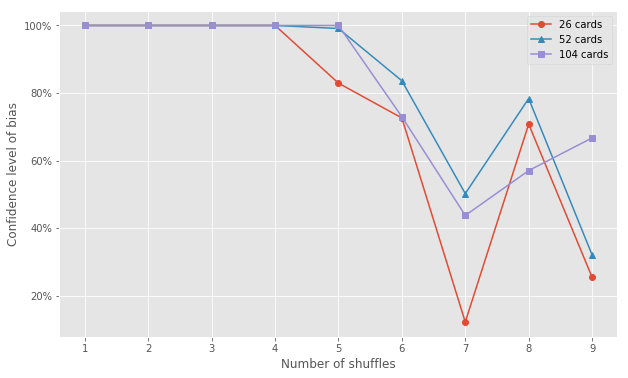

In [6]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib.ticker import PercentFormatter


pl.style.use('ggplot')
fig = pl.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, 10), confidences(26), 'o-', label='26 cards')
ax.plot(range(1, 10), confidences(52), '^-', label='52 cards')
ax.plot(range(1, 10), confidences(104), 's-', label='104 cards')
pl.xlabel('Number of shuffles')
pl.ylabel('Confidence level of bias')
ax.legend()
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

As can be seen in the above, confidence in rejecting the null hypothesis of independence between card and card position dips below 90% for 26 cards after 5 shuffles, and for 52 and 104 cards after 6 shuffles, with confidences dropping below 50% for all deck sizes after 7 shuffles.

_Do you think these findings are robust to small changes to the shuffling model? Why or why not? If you’re having trouble thinking of changes to the model, consider how one might model wear and tear on the cards, for instance if they became sticky from years of fun times and spilled drinks._

Depending on the nature of the alteration, changes to the shuffling model can drastically alter the randomness of the deck after shuffling. Consider, for instance, the case in which cards are dropped from the left or right sub-decks two at a time. In this scenario, pairs of initially adjacent cards can only be separated within the deck during the "cut" phase - meaning, e.g., in a 52-card deck, that only 7 of 26 pairs could be separated at best.